In [1]:
import os
import cv2
import random
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm.keras import TqdmCallback

In [3]:
RANDOM_SEED = 227
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
path = "/kaggle/input/cidaut-ai-fake-scene-classification-2024"
os.listdir(path)

['sample_submission.csv', 'train.csv', 'Test', 'Train']

In [5]:
train_files = sorted(os.listdir(path + "/Train"), key=lambda x : int(x.split('.')[0]))
print(len(train_files))

720


In [6]:
df = pd.read_csv(path + '/train.csv')
df.head()

,image,label
0,1.jpg,editada
1,2.jpg,real
2,3.jpg,real
3,6.jpg,editada
4,8.jpg,real


In [7]:
df['label'].unique()

array(['editada', 'real'], dtype=object)

In [8]:
df['image'] = df['image'].apply(lambda x : path + '/Train/' + x)
df.head()

,image,label
0,/kaggle/input/cidaut-ai-fake-scene-classificat...,editada
1,/kaggle/input/cidaut-ai-fake-scene-classificat...,real
2,/kaggle/input/cidaut-ai-fake-scene-classificat...,real
3,/kaggle/input/cidaut-ai-fake-scene-classificat...,editada
4,/kaggle/input/cidaut-ai-fake-scene-classificat...,real


In [9]:
df['label'].value_counts()

label
real       405
editada    315
Name: count, dtype: int64

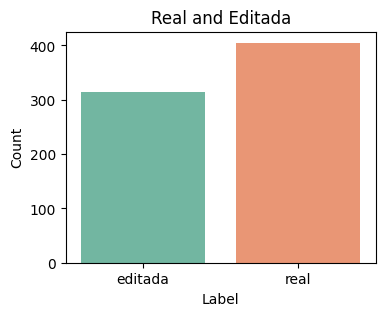

In [10]:
plt.figure(figsize=(4, 3))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Real and Editada')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [11]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df['label'].unique()

array([0, 1])

- 1 = real
- 0 = editada

In [12]:
def convert_image(image):
    img = cv2.imread(image)
    img = img_to_array(img)
    img = cv2.resize(img, (224, 224))
    return (img)

df['processed_image'] = df['image'].apply(convert_image)

In [13]:
df.head()

,image,label,processed_image
0,/kaggle/input/cidaut-ai-fake-scene-classificat...,0,"[[[12.0, 12.0, 12.0], [13.0, 13.0, 13.0], [13...."
1,/kaggle/input/cidaut-ai-fake-scene-classificat...,1,"[[[230.0, 190.0, 141.0], [230.0, 190.0, 141.0]..."
2,/kaggle/input/cidaut-ai-fake-scene-classificat...,1,"[[[214.41837, 162.91837, 131.70409], [125.5714..."
3,/kaggle/input/cidaut-ai-fake-scene-classificat...,0,"[[[147.78827, 177.78827, 166.78827], [127.7857..."
4,/kaggle/input/cidaut-ai-fake-scene-classificat...,1,"[[[65.77041, 80.41326, 97.48469], [90.41326, 9..."


In [14]:
x = np.stack(df['processed_image'].values)
y = np.array(df['label']).reshape(-1, 1)

In [15]:
print(len(x))
print(x.shape)
print(y.shape)

720
(720, 224, 224, 3)
(720, 1)


In [16]:
x_train, x_test,y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=RANDOM_SEED)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=RANDOM_SEED)

In [17]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(648, 224, 224, 3)
(15, 224, 224, 3)
(57, 224, 224, 3)


In [18]:
x_train = x_train / 255
x_test_scaled = x_test / 255
x_val = x_val / 255

In [19]:
def build_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    flatten_layer = Flatten()(base_model.output)
    dense_layer1 = Dense(1024, activation='relu')(flatten_layer)
    dense_layer2 = Dense(512, activation='relu')(dense_layer1)
    output_layer = Dense(1, activation='sigmoid')(dense_layer2)

    model = Model(inputs=base_model.input, outputs=output_layer)
    return model

In [20]:
model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 126,874,497 (483.99 MB)

 Trainable params: 103,286,785 (394.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
EPOCHS = 60
initial_lr = 1e-5
decay_steps = 10
decay_rate = 1.0

lr_scheduler = ExponentialDecay(initial_lr, decay_steps, decay_rate)
training_optimizer = Adam(learning_rate=lr_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=training_optimizer, loss='binary_crossentropy', metrics=['accuracy','precision','recall','auc','binary_accuracy'])

In [23]:
history = model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS, validation_data=(x_val, y_val), verbose=0, callbacks=[early_stopping, TqdmCallback(verbose=2)])

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

  0%|          | 0.00/21.0 [00:00<?, ?batch/s]

In [24]:
save_path = '/kaggle/working/covid-model.h5'
model.save(save_path)

In [25]:
def plot_metric(metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

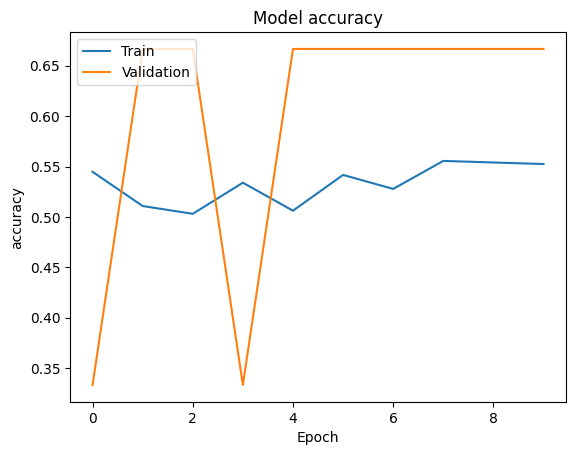

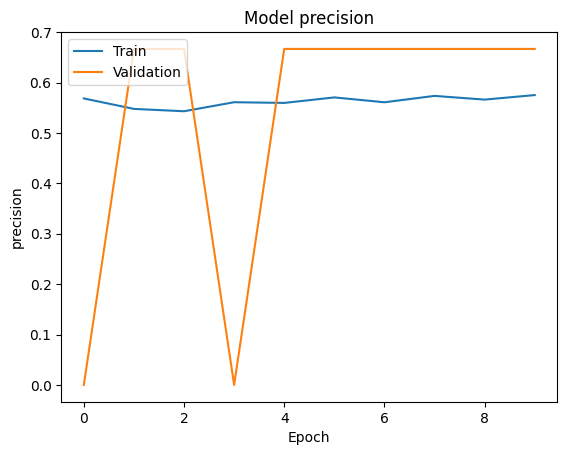

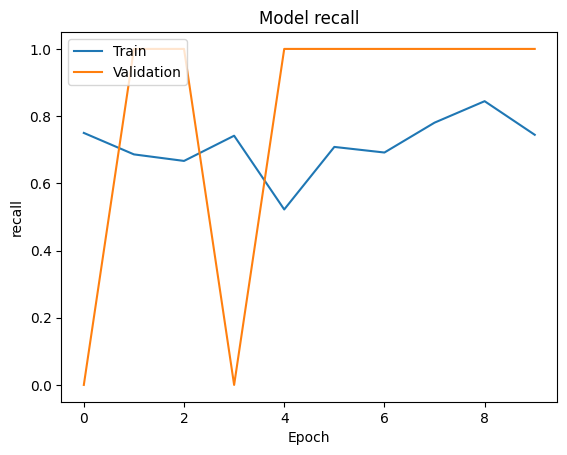

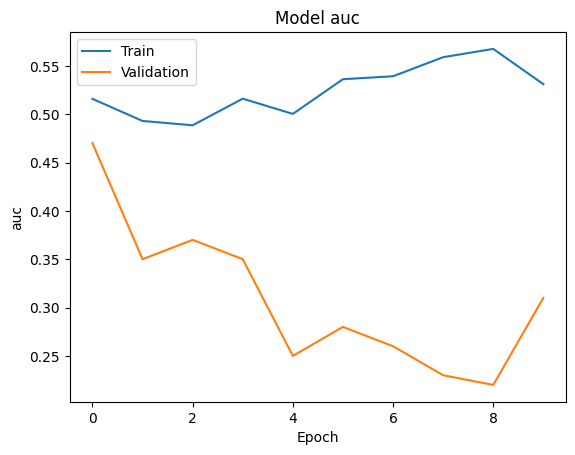

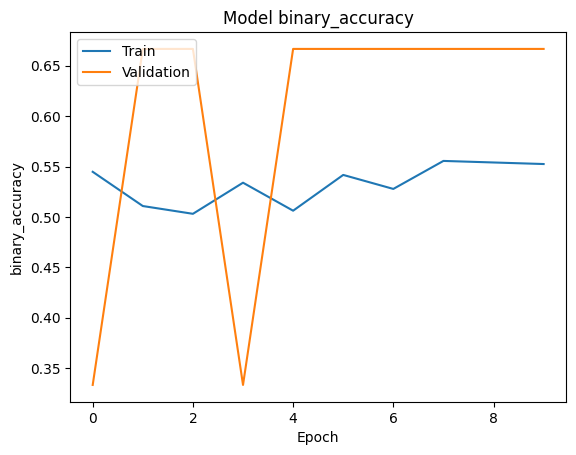

In [26]:
metrics=['accuracy','precision','recall','auc','binary_accuracy']

for metric in metrics:
    plot_metric(metric)

In [27]:
y_pred = model.predict(x_test)
y_pred_classes = (y_pred >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy: ", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step
Test Accuracy:  0.43859649122807015


In [28]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['editada', 'real']))


Classification Report:
              precision    recall  f1-score   support

     editada       0.40      0.86      0.54        22
        real       0.67      0.17      0.27        35

    accuracy                           0.44        57
   macro avg       0.53      0.52      0.41        57
weighted avg       0.56      0.44      0.38        57



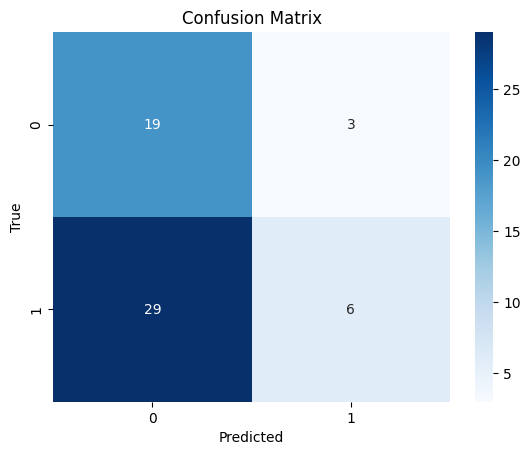

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()